# Multi-Class Image Classification for Robust Outdoor Weather Recognition


**Authors**: [Dominic Muli](mailto:dominic.muli@student.moringaschool.com), [Evangeline Ngunjiri](mailto:evangeline.ngunjiri@student.moringaschool.com), and [Ivy Ndunge](mailto:ivy.ndunge@student.moringaschool.com)

## 1.0) Project Overview

In the "Visual Weather Recognition with Deep Learning" project, the objective is to create a sophisticated Convolutional Neural Network (CNN) model capable of accurately classifying diverse weather conditions based on visual cues in images. By leveraging deep learning techniques, the project aims to develop a robust system that can distinguish between various weather phenomena, including sunny, rainy, cloudy, and sunrise scenes. The key components include the collection and exploration of a comprehensive dataset, data preprocessing with augmentation to enhance model generalization, and the design of a specialized CNN architecture. The model will be trained and evaluated, with a focus on metrics such as accuracy, precision, and recall. Visualization techniques will be employed to gain insights into the CNN's interpretation of different weather patterns, and considerations for potential deployment scenarios will be explored.

Technologies utilized in this project include Python as the primary programming language, TensorFlow for building and training the CNN and Matplotlib and Seaborn for visualization.

## 1.1) Business Problem


The business objective is to leverage the multiclass weather dataset to advance the development of image classification models capable of accurately recognizing and categorizing different weather conditions. By doing so, this project aims to enhance the capabilities of outdoor weather analysis, offering valuable insights for sectors ranging from transportation and agriculture to urban planning and disaster preparedness.

## 1.2) Objectives

The primary aim of this project is to develop an advanced Convolutional Neural Network (CNN) model for accurate and robust weather classification based on visual cues in images. Leveraging the power of deep learning, this project seeks to create a sophisticated system capable of distinguishing between various weather conditions, including sunny, rainy, cloudy, and sunrise scenes. The objective extends beyond mere image recognition to the creation of a model that exhibits high-level understanding of complex visual patterns associated with different weather phenomena.

* Achieve an accuracy of at least 90% in classifying outdoor weather images across various conditions.
* Develop a model that is robust to variations in lighting, camera angles, and weather intensity.
* Minimize computational resources required for model training and inference.

## 1.3) Metric of Success

* Accuracy: Percentage of correctly classified weather images.
* Precision and Recall: Measures of how well the model identifies specific weather classes.
* F1-Score: Harmonic mean of precision and recall, providing a balanced measure of model performance.
* Inference Speed: Time taken to classify a single image.
* Computational Cost: Resources required to train and run the model.
* A robust and accurate multi-class image classification model for outdoor weather recognition.
* Potential applications in various sectors such as agriculture, aviation, and disaster management.

## 1.4) Data Relevance and Validation

The data available is relevant for the intended analysis and predictions

## 2.0) Understanding the Data

Multi-Class Image Classification of Outdoor Weather Dataset Description:

Name: Multi-class Weather Dataset for Image Classification

Size: 91.2MB

Format: Images with corresponding class labels (rain, cloudy, sunrise, shine)

Classes: 4
* Rain
* Cloudy
* Sunrise
* Shine

The data for this project is obtained from the [Mendeley Data website](https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com).

## 2.1) Reading the Data

### 2.1.1) Installations

In [37]:
# installations
# %pip install tensorflow
# %conda install -c conda-forge scikit-image
# %pip install pillow
# %pip install tqdm
# %pip install --upgrade numpy
# %pip install --upgrade scipy


### 2.1.2) Importing Relevant Libraries

In [1]:
# importing necessary libraries
import os, shutil
import itertools
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
import random
from collections import Counter
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
# from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
np.random.seed(123)

%matplotlib inline

### 2.1.3) Reading the Data

In [2]:
# reading the data

# path to the dataset
dataset_path = './data/dataset2/'

# List of supported weather classes based on file names
weather_classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Dictionary to map weather class names to numerical labels
label_map = {weather_class: idx for idx, weather_class in enumerate(weather_classes)}

images_list = []
labels_list = []

filepaths = []
word_labels = []

# Function to extract class label from filename
def extract_label(filename):
    for weather_class in weather_classes:
        if weather_class in filename:
            return label_map[weather_class]
    return None

# Loop through each image file in the dataset directory
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    
    try:
        # Open image using PIL
        img = Image.open(img_path)
        
        # Convert image to numpy array
        img = np.array(img)
        
        # Extract class label from the filename
        label = extract_label(img_file)
        word_label = [key for key, value in label_map.items() if value == label][0]
        if label is not None:
            # Append the image and its label to the lists
            images_list.append(img)
            labels_list.append(label)
            filepaths.append(img_path)
            word_labels.append(word_label)

    except Exception as e:
        print(f"Error processing image '{img_file}': {e}")

# Convert lists to numpy arrays
images = np.array(images_list)
labels = np.array(labels_list)
data = {'filepaths': filepaths, 'word_labels': word_labels}
df = pd.DataFrame(data)

print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")
df

Processing images: 100%|██████████| 1125/1125 [00:09<00:00, 123.63it/s]

Total images: 1125
Total labels: 1125


,filepaths,word_labels
0,./data/dataset2/cloudy1.jpg,cloudy
1,./data/dataset2/cloudy10.jpg,cloudy
2,./data/dataset2/cloudy100.jpg,cloudy
3,./data/dataset2/cloudy101.jpg,cloudy
4,./data/dataset2/cloudy102.jpg,cloudy
...,...,...
1120,./data/dataset2/sunrise95.jpg,sunrise
1121,./data/dataset2/sunrise96.jpg,sunrise
1122,./data/dataset2/sunrise97.jpg,sunrise
1123,./data/dataset2/sunrise98.jpg,sunrise


## 2.2) EDA before Preprocessing

### 2.2.1) Image preview

We will inspect 20 random images from the dataset

<ipython-input-24-9e0dc8a099de>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, num_samples/5, i + 1)


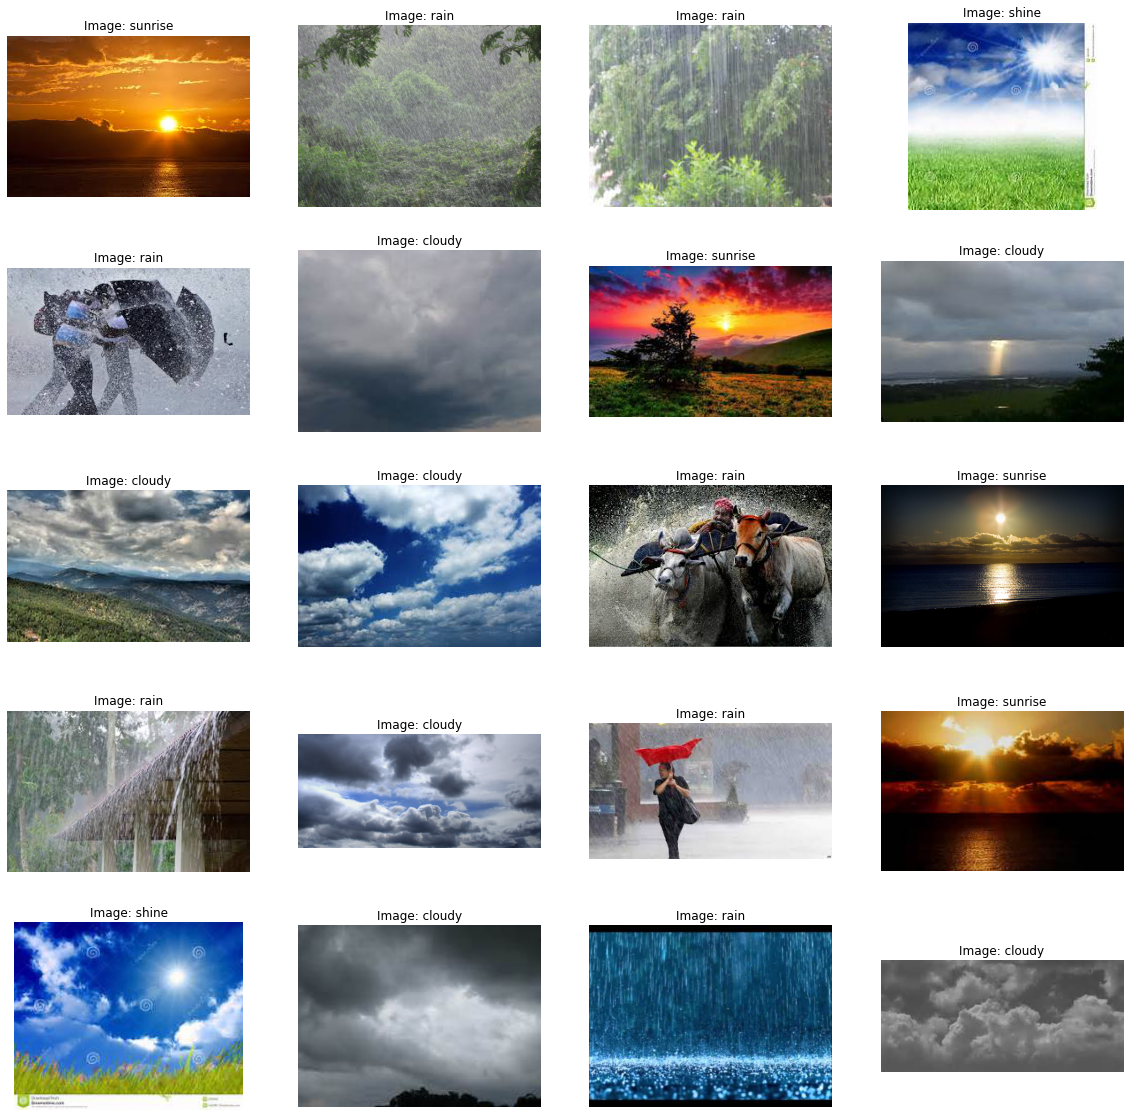

In [24]:
# previewing random images

def visualize_random_images(num_samples=20):
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        random_idx = random.randint(0, len(images) - 1) 
        random_image = images[random_idx]
        
        filename = [key for key, value in label_map.items() if value == labels[random_idx]][0]
        
        # Displaying the image
        plt.subplot(5, num_samples/5, i + 1)
        plt.imshow(random_image)
        plt.title(f"Image: {filename}")
        plt.axis("off")
    plt.show()

visualize_random_images()


### 2.2.2) Weather Class Distribution

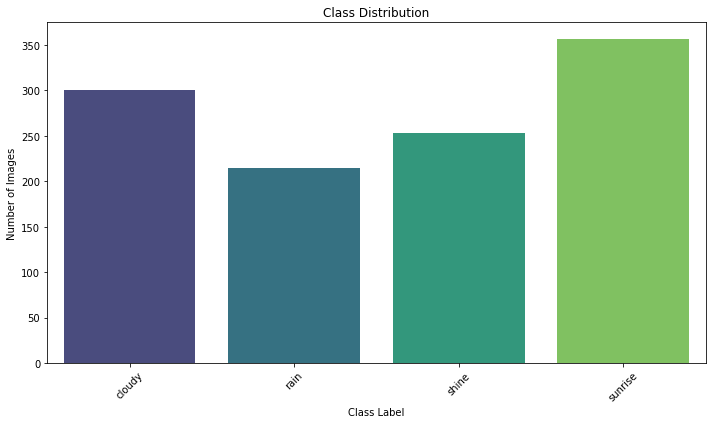

Counter({0: 300, 1: 215, 2: 253, 3: 357})

In [4]:
# class Distribution Visualization

# Get class titles from the label_map
class_titles = [key for key in label_map.keys()]

# Calculate class distribution using Counter
class_distribution = Counter(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_titles, y=list(class_distribution.values()), palette='viridis')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution

Observation: The weather classes are relatively evenly distributed. There are 300 images showing cloudy weather, 215 images showing rainy weather, 253 images showing shinny weather, and 357 images showing sunrise. This shows class imbalance.

### 2.2.3) Image Size Distribution

Processing images: 100%|██████████| 1125/1125 [00:00<00:00, 2829.96it/s]


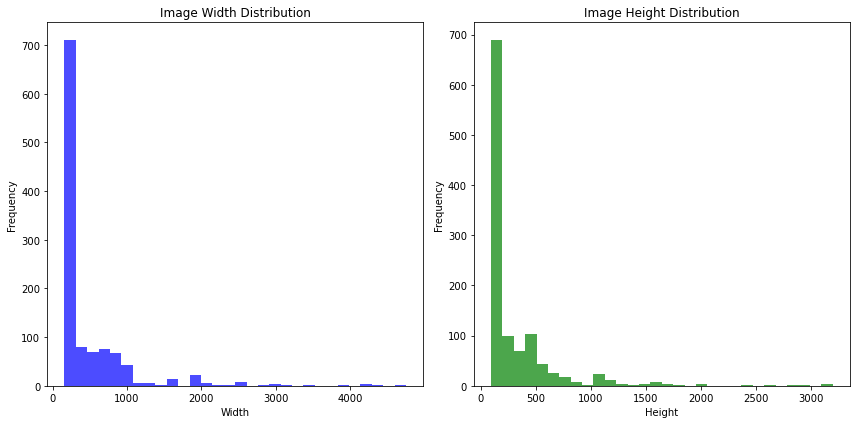

In [5]:
# image size distribution
image_sizes = []
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Observation: The images have varying sizes (height and width).

### 2.2.4) Image Pixel Distribution

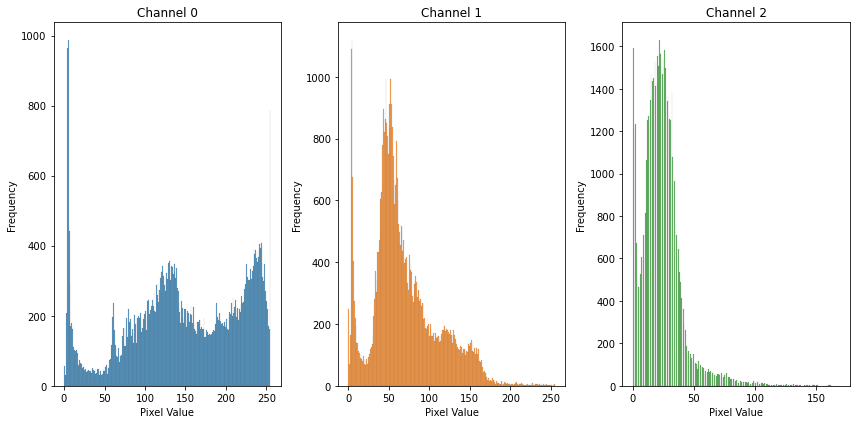

In [6]:
# Convert image to a NumPy array
img_array = np.array(img)

# Display pixel value distributions
plt.figure(figsize=(12, 6))

# Plot histograms for each color channel
for i in range(img_array.shape[2]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(img_array[:, :, i].ravel(), bins=256, color=f'C{i}', alpha=0.7)
    plt.title(f'Channel {i}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()

Observation: the RGB color distribution 

### 2.2.5) Label Mappings

In [7]:
# viewing label mappings
for key, value in label_map.items():
    print(f"{key} : {value}")

cloudy : 0
rain : 1
shine : 2
sunrise : 3


## 2.3) Data Preprocessing

### 2.3.1) Splitting the Data

In [3]:
# Setting the paths for the train, test, and validation directories
train_imgs = "./data/traindataset/"
test_imgs = "./data/testdataset/"
val_imgs = "./data/valdataset/"

# Defining split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Creating directories
os.makedirs(train_imgs, exist_ok=True)
os.makedirs(test_imgs, exist_ok=True)
os.makedirs(val_imgs, exist_ok=True)

# Splitting the DataFrame into train, validation, and test sets
train_df, df_2 = train_test_split(df, train_size=train_ratio, random_state=42, shuffle=True)
val_df, test_df = train_test_split(df_2, test_size=val_ratio/(test_ratio+val_ratio), random_state=42, shuffle=True)

# Function to copy/move files to subdirectories based on weather classes
def organize_images_by_weather_classes(file_list, source_dir, destination_dir, classes):
    for weather_class in classes:
        os.makedirs(os.path.join(destination_dir, weather_class), exist_ok=True)

    for filepath, label in zip(file_list['filepaths'], file_list['word_labels']):
        filename = os.path.basename(filepath)
        weather_class = label.lower()
        if weather_class in classes:
            destination_path = os.path.join(destination_dir, weather_class, filename)
            shutil.copy(filepath, destination_path)

# Copying and organizing images to train directory by weather classes
organize_images_by_weather_classes(train_df, dataset_path, train_imgs, weather_classes)

# Copying and organizing images to validation directory by weather classes
organize_images_by_weather_classes(val_df, dataset_path, val_imgs, weather_classes)

# Copying and organizing images to test directory by weather classes
organize_images_by_weather_classes(test_df, dataset_path, test_imgs, weather_classes)

# Function to count number of images in each subdirectory
def count_images_in_subdirectories(parent_directory, classes):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Dictionary to store image counts for each class
    image_counts = {cls: 0 for cls in classes}

    # Iterating through each class directory and counting images
    for cls in classes:
        directory_path = os.path.join(parent_directory, cls)
        if os.path.exists(directory_path):
            for filename in os.listdir(directory_path):
                if any(filename.lower().endswith(ext) for ext in image_extensions):
                    image_counts[cls] += 1

    return image_counts

# Getting the count of images in each subdirectory
num_train_images = count_images_in_subdirectories(train_imgs, weather_classes)
num_val_images = count_images_in_subdirectories(val_imgs, weather_classes)
num_test_images = count_images_in_subdirectories(test_imgs, weather_classes)

# Displaying number of images in each class within directories
for cls in weather_classes:
    print(f"There are {num_train_images[cls]} {cls} images in the training set")
    print(f"There are {num_val_images[cls]} {cls} images in the validation set")
    print(f"There are {num_test_images[cls]} {cls} images in the test set")

There are 209 cloudy images in the training set
There are 45 cloudy images in the validation set
There are 46 cloudy images in the test set
There are 143 rain images in the training set
There are 33 rain images in the validation set
There are 39 rain images in the test set
There are 178 shine images in the training set
There are 37 shine images in the validation set
There are 38 shine images in the test set
There are 257 sunrise images in the training set
There are 54 sunrise images in the validation set
There are 46 sunrise images in the test set


### 2.3.1) Image Generation

### 2.3.2) Image Data Augmentation

In [4]:
# data augmentation and flow_from_directory
target_width = 224
target_height = 224
img_size = (target_width, target_height)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_data_gen = ImageDataGenerator(rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Flowing data from directories
train_gen = train_data_gen.flow_from_directory(train_imgs, target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = val_data_gen.flow_from_directory(val_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = test_data_gen.flow_from_directory(test_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 787 images belonging to 4 classes.
Found 169 images belonging to 4 classes.
Found 169 images belonging to 4 classes.


In [5]:
# Class weights to solve for class imbalance
class_count = len(list(train_gen.class_indices.keys()))

class_weights = compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))

c:\Users\Dominc\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

## 2.4) Building Model

In [48]:
# Creating an ANN model
ann_model = Sequential([
    Flatten(input_shape=(target_width, target_height, 3)), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(weather_classes), activation='softmax')
])

# Compiling the model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = ann_model.fit(train_gen, epochs=20, validation_data=valid_gen)

Epoch 1/20
25/25 [==============================] - 18s 718ms/step - loss: 27.7204 - accuracy: 0.3990 - val_loss: 1.2125 - val_accuracy: 0.5325
Epoch 2/20
25/25 [==============================] - 17s 692ms/step - loss: 1.2846 - accuracy: 0.5057 - val_loss: 1.1276 - val_accuracy: 0.4852
Epoch 3/20
25/25 [==============================] - 21s 844ms/step - loss: 1.1758 - accuracy: 0.4778 - val_loss: 1.0299 - val_accuracy: 0.5621
Epoch 4/20
25/25 [==============================] - 18s 733ms/step - loss: 1.1431 - accuracy: 0.4727 - val_loss: 1.0426 - val_accuracy: 0.5562
Epoch 5/20
25/25 [==============================] - 18s 736ms/step - loss: 1.1695 - accuracy: 0.4676 - val_loss: 1.0490 - val_accuracy: 0.5799
Epoch 6/20
25/25 [==============================] - 18s 721ms/step - loss: 1.1159 - accuracy: 0.5019 - val_loss: 1.0049 - val_accuracy: 0.5562
Epoch 7/20
25/25 [==============================] - 39s 2s/step - loss: 1.1252 - accuracy: 0.4740 - val_loss: 1.0025 - val_accuracy: 0.5562
E

In [49]:
# Evaluating the model on the test data
test_loss2, test_accuracy2 = ann_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy2 * 100:.2f}%")
print(f"Test Loss: {test_loss2:.4f}")

# Displaying the model summary
ann_model.summary()

6/6 [==============================] - 3s 482ms/step - loss: 1.0370 - accuracy: 0.5089
Test Accuracy: 50.89%
Test Loss: 1.0370
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 19,268,228
Trainable params: 19,268,228
Non-trainable params: 0
_________________________________________________________________


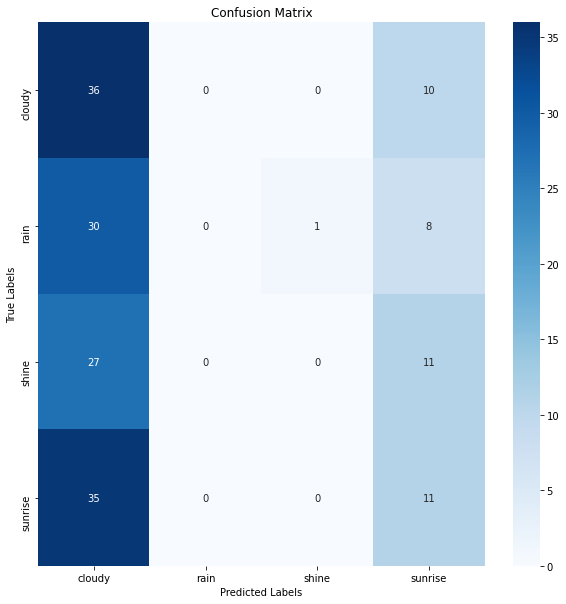

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.78      0.41        46
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        38
           3       0.28      0.24      0.26        46

    accuracy                           0.28       169
   macro avg       0.14      0.26      0.17       169
weighted avg       0.15      0.28      0.18       169



c:\Users\Dominc\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# Making predictions on the test data using the trained model
y_pred = ann_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes from the test data
true_classes = test_gen.classes

# Calculating confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Getting the class labels
class_labels = weather_classes

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=((10, 10)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
class_report = classification_report(true_classes, y_pred_classes)

# Print classification report
print("Classification Report:")
print(class_report)


In [51]:
# Creating a CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(weather_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Training the model with callbacks
history = model.fit(train_gen, epochs=50, validation_data=valid_gen,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
25/25 [==============================] - 189s 8s/step - loss: 1.3530 - accuracy: 0.5502 - val_loss: 0.9294 - val_accuracy: 0.6627
Epoch 2/50
25/25 [==============================] - 134s 5s/step - loss: 1.0187 - accuracy: 0.6544 - val_loss: 0.8962 - val_accuracy: 0.6154
Epoch 3/50
25/25 [==============================] - 78s 3s/step - loss: 0.9022 - accuracy: 0.6696 - val_loss: 0.7218 - val_accuracy: 0.7219
Epoch 4/50
25/25 [==============================] - 153s 6s/step - loss: 0.7800 - accuracy: 0.7205 - val_loss: 0.6006 - val_accuracy: 0.8698
Epoch 5/50
25/25 [==============================] - 117s 5s/step - loss: 0.6712 - accuracy: 0.7662 - val_loss: 1.3561 - val_accuracy: 0.6095
Epoch 6/50
25/25 [==============================] - 143s 6s/step - loss: 0.6828 - accuracy: 0.7573 - val_loss: 0.5473 - val_accuracy: 0.8047
Epoch 7/50
25/25 [==============================] - 146s 6s/step - loss: 0.6692 - accuracy: 0.7878 - val_loss: 0.5817 - val_accuracy: 0.7929
Epoch 8/50
25/

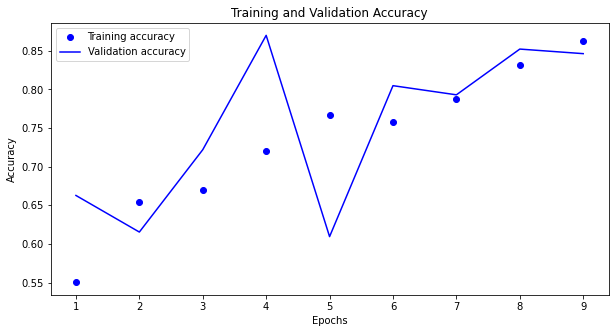

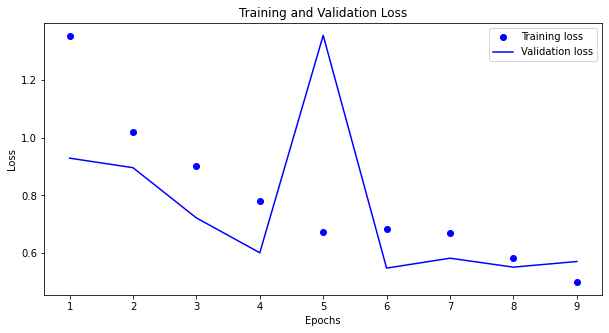

In [52]:
# Plotting History

# Extracting metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [53]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Displaying the model summary
model.summary()

6/6 [==============================] - 7s 1s/step - loss: 0.6283 - accuracy: 0.7515
Test Accuracy: 75.15%
Test Loss: 0.6283
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0      

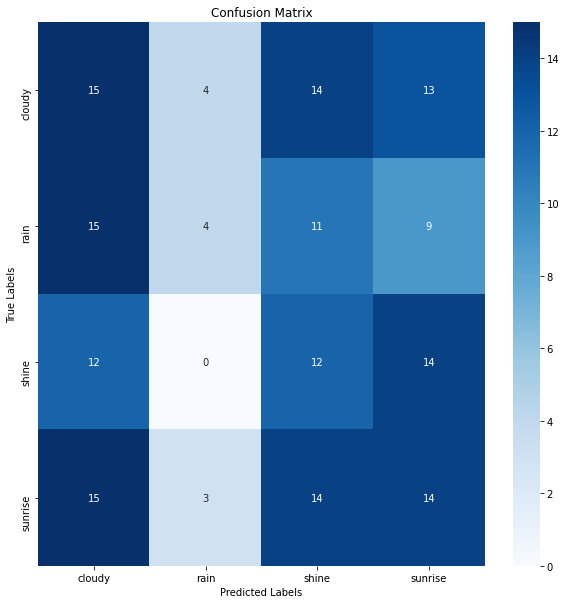

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.33      0.29        46
           1       0.36      0.10      0.16        39
           2       0.24      0.32      0.27        38
           3       0.28      0.30      0.29        46

    accuracy                           0.27       169
   macro avg       0.29      0.26      0.25       169
weighted avg       0.28      0.27      0.26       169



In [54]:
# Making predictions on the test data using the trained model
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes from the test data
true_classes = test_gen.classes

# Calculating confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Getting the class labels
class_labels = weather_classes

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=((10, 10)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
class_report = classification_report(true_classes, y_pred_classes)

# Print classification report
print("Classification Report:")
print(class_report)

In [7]:
# Creating pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape, include_top=False, weights='imagenet', pooling='max'
)

# Defining model architecture
model = Sequential([
    base_model,
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training the model
epochs = 50

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
    
)

9412608/9406464 [==============================] - 10s 1us/step
Epoch 1/50
25/25 [==============================] - 99s 4s/step - loss: 5.3695 - accuracy: 0.3329 - val_loss: 1.3499 - val_accuracy: 0.5444
Epoch 2/50
25/25 [==============================] - 96s 4s/step - loss: 3.2241 - accuracy: 0.4816 - val_loss: 1.0550 - val_accuracy: 0.6095
Epoch 3/50
25/25 [==============================] - 96s 4s/step - loss: 1.8839 - accuracy: 0.6188 - val_loss: 0.9398 - val_accuracy: 0.6923
Epoch 4/50
25/25 [==============================] - 99s 4s/step - loss: 1.4142 - accuracy: 0.7281 - val_loss: 1.2590 - val_accuracy: 0.6331
Epoch 5/50
25/25 [==============================] - 98s 4s/step - loss: 0.8782 - accuracy: 0.7942 - val_loss: 1.5582 - val_accuracy: 0.5444
Epoch 6/50
25/25 [==============================] - 102s 4s/step - loss: 0.6832 - accuracy: 0.8272 - val_loss: 1.1914 - val_accuracy: 0.6331
Epoch 7/50
25/25 [==============================] - 104s 4s/step - loss: 0.8179 - accuracy: 0.8

In [8]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Summary of the best model
model.summary()

6/6 [==============================] - 2s 355ms/step - loss: 1.1939 - accuracy: 0.6213
Test Accuracy: 62.13%
Test Loss: 1.1939
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 2,552,836
Non-trainable params: 34,112
______________________________________________

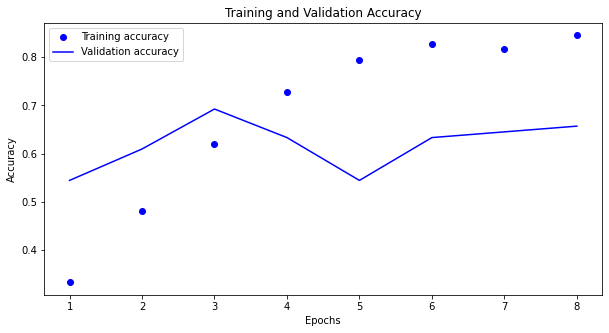

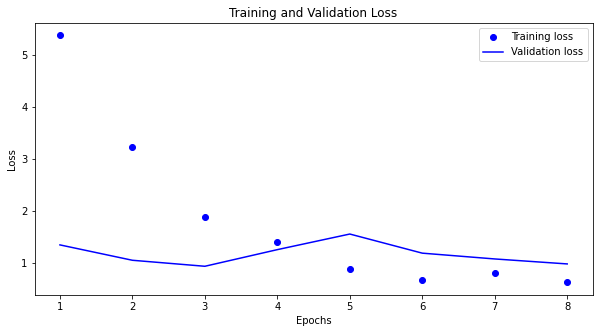

In [13]:
# Plotting history

# Extracting metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

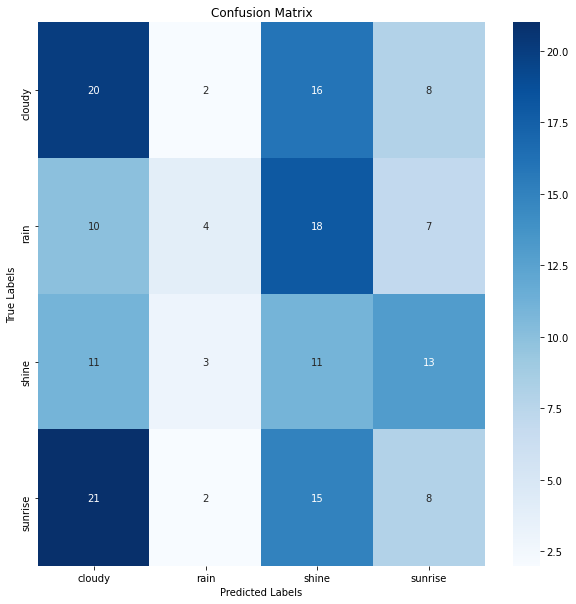

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.43      0.37        46
           1       0.36      0.10      0.16        39
           2       0.18      0.29      0.22        38
           3       0.22      0.17      0.20        46

    accuracy                           0.25       169
   macro avg       0.27      0.25      0.24       169
weighted avg       0.27      0.25      0.24       169



In [14]:
# Making predictions on the test data using the trained model
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes from the test data
true_classes = test_gen.classes

# Calculating confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Getting the class labels
class_labels = weather_classes

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=((10, 10)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
class_report = classification_report(true_classes, y_pred_classes)

# Print classification report
print("Classification Report:")
print(class_report)

In [15]:

# Create pre-trained model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape, include_top=False, weights='imagenet', pooling='max'
)

# Define your model architecture
model = Sequential([
    base_model,
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
epochs = 50

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
25/25 [==============================] - 95s 4s/step - loss: 5.4097 - accuracy: 0.3367 - val_loss: 2.2668 - val_accuracy: 0.5148
Epoch 2/50
25/25 [==============================] - 93s 4s/step - loss: 3.0211 - accuracy: 0.5044 - val_loss: 1.9209 - val_accuracy: 0.5740
Epoch 3/50
25/25 [==============================] - 103s 4s/step - loss: 1.6375 - accuracy: 0.6709 - val_loss: 1.9509 - val_accuracy: 0.5680
Epoch 4/50
25/25 [==============================] - 101s 4s/step - loss: 1.3783 - accuracy: 0.7065 - val_loss: 1.8427 - val_accuracy: 0.5858
Epoch 5/50
25/25 [==============================] - 101s 4s/step - loss: 0.9790 - accuracy: 0.7865 - val_loss: 2.0581 - val_accuracy: 0.6036
Epoch 6/50
25/25 [==============================] - 115s 5s/step - loss: 0.7310 - accuracy: 0.8297 - val_loss: 1.9048 - val_accuracy: 0.5917
Epoch 7/50
25/25 [==============================] - 94s 4s/step - loss: 0.7346 - accuracy: 0.8234 - val_loss: 1.3386 - val_accuracy: 0.6923
Epoch 8/50
25/25

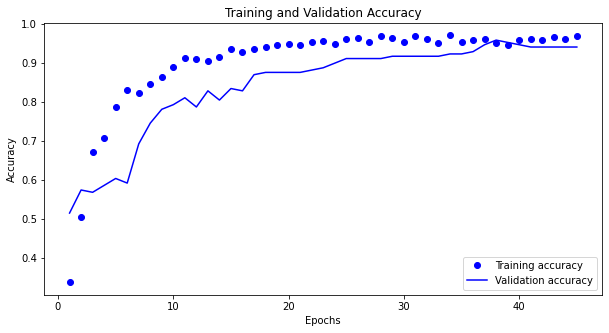

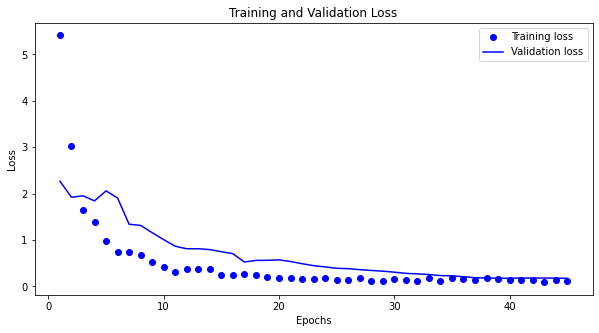

In [17]:
# Plotting history

# Extracting metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Summary of the best model
model.summary()

6/6 [==============================] - 3s 441ms/step - loss: 0.1118 - accuracy: 0.9645
Test Accuracy: 96.45%
Test Loss: 0.1118
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 2,552,836
Non-trainable params: 34,112
____________________________________________

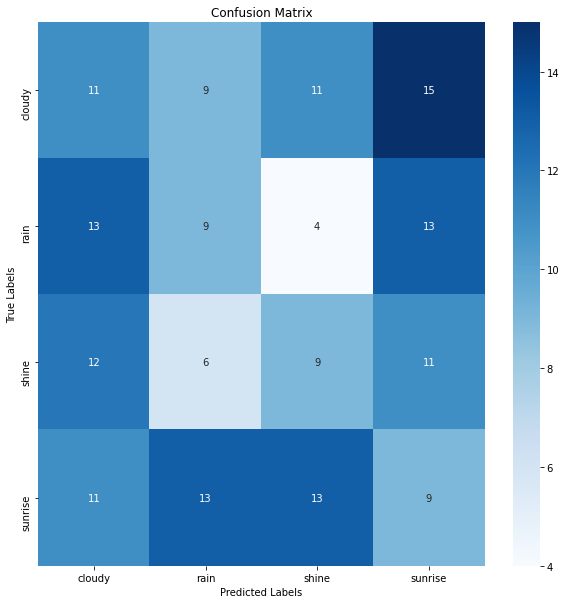

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.24      0.24        46
           1       0.24      0.23      0.24        39
           2       0.24      0.24      0.24        38
           3       0.19      0.20      0.19        46

    accuracy                           0.22       169
   macro avg       0.23      0.23      0.23       169
weighted avg       0.23      0.22      0.23       169



In [16]:
# Making predictions on the test data using the trained model
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes from the test data
true_classes = test_gen.classes

# Calculating confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Getting the class labels
class_labels = weather_classes

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=((10, 10)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generating classification report
class_report = classification_report(true_classes, y_pred_classes)

# Print classification report
print("Classification Report:")
print(class_report)

In [ ]:
# Saving the best model
# model.save('`Weather_Recognition_Model.h5`')

## 2.5) Conclusion

## 2.6) Recommendation